In [1]:
import os
import cv2
import glob
import keras
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import albumentations as A
from tqdm.notebook import tqdm as tqdm

Using TensorFlow backend.


In [2]:
folder_name = './'

In [3]:
#load img path
image_folder = os.path.join(folder_name,'image')
image_path_list = glob.glob(image_folder+'/*.PNG')
# 可以瞭解 glob 用法
image_path_list.sort()

label_folder = os.path.join(folder_name,'label')
label_path_list = glob.glob(label_folder+'/*.PNG')
label_path_list.sort()

add_label_folder = os.path.join(folder_name,'add_img')
add_label_path_list = glob.glob(add_label_folder+'/*.PNG')
add_label_path_list.sort()


print(len(image_path_list), len(label_path_list), len(add_label_path_list))

200 200 200


In [4]:
#class color in BGR
img_whiteside = np.array([255,255,255])
background = np.array([0,0,0])
bacmixgums = np.array([16,78,128])
tooth = np.array([0,255,255])
artifical_crown = np.array([255,255,0])
cavity = np.array([0,0,255])
overlap = np.array([255,0,255])
gums = np.array([255,0,0])
cej = np.array([0,255,0])
img_depressed = np.array([3,128,253])
gray = np.array([125,125,125])

In [5]:
def show_pixel_set(img_nparray):
    a = img_nparray
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [6]:
#class color in BGR
img_whiteside = np.array([255,255,255])
background = np.array([0,0,0])
bacmixgums = np.array([16,78,128])
tooth = np.array([0,255,255])
artifical_crown = np.array([255,255,0])
cavity = np.array([0,0,255])
overlap = np.array([255,0,255])
gums = np.array([255,0,0])
cej = np.array([0,255,0])
img_depressed = np.array([3,128,253])

def get_combine_img(o_lab, add_lab):
    for j in range(o_lab.shape[0]):
        for i in range(o_lab.shape[0]):
            if (add_lab[j][i]==img_whiteside).all():
                 o_lab[j][i]=img_whiteside
            elif (add_lab[j][i]==background).all():
                 o_lab[j][i]=background
            elif (add_lab[j][i]==bacmixgums).all():
                 o_lab[j][i]=bacmixgums
            elif (add_lab[j][i]==tooth).all():
                 o_lab[j][i]=tooth
            elif (add_lab[j][i]==artifical_crown).all():
                 o_lab[j][i]=artifical_crown
            elif (add_lab[j][i]==cavity).all():
                 o_lab[j][i]=cavity
            elif (add_lab[j][i]==overlap).all():
                 o_lab[j][i]=overlap
            elif (add_lab[j][i]==gums).all():
                 o_lab[j][i]=gums
            elif (add_lab[j][i]==cej).all():
                 o_lab[j][i]=cej
            elif (add_lab[j][i]==img_depressed).all():
                 o_lab[j][i]=img_depressed
    return o_lab
# 用 dict 改看看(?

# Combine you modify img color in original label image

  0%|          | 0/15 [00:00<?, ?it/s]

(1024, 1024, 3)


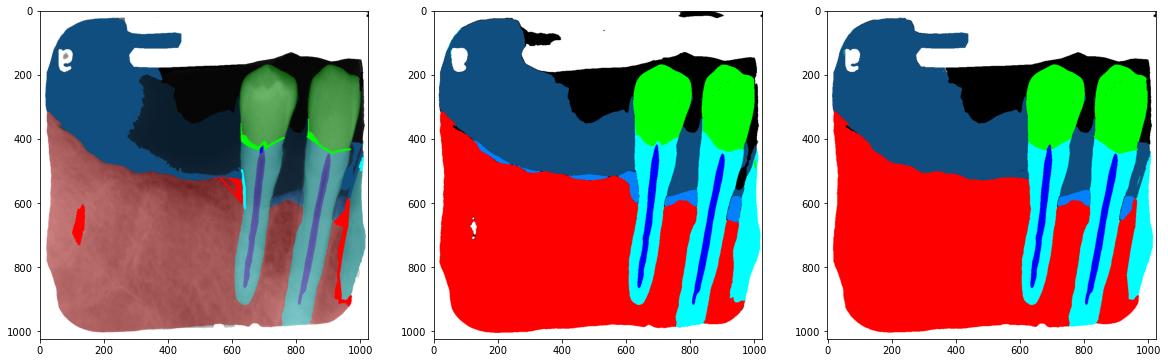

(1024, 1024, 3)


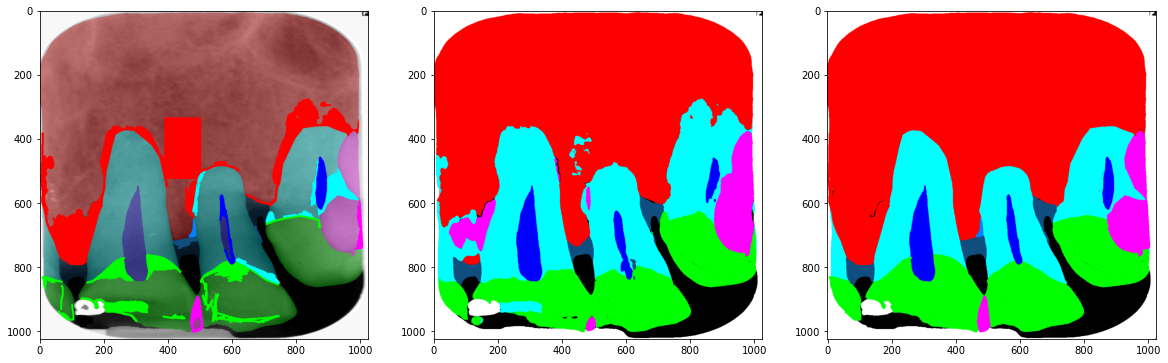

(1024, 1024, 3)


KeyboardInterrupt: 

In [7]:
#你只有修該後面9張,我另外放一個資料夾坐處理
add_label_folder = os.path.join(folder_name,'add_img_pick')

add_label_path_list = glob.glob(add_label_folder+'/*.PNG')
add_label_path_list.sort()
# print(add_label_path_list)
save_path = './label_combine'

for add_label_path in tqdm(add_label_path_list, total=len(add_label_path_list)):
    img_name = add_label_path.split('\\')[-1]
#     print(img_name)
#     print(label_path_list)
    add_label_img = cv2.imread(add_label_path)
    print(add_label_img.shape)
    label_path = [img_path for img_path in label_path_list if img_name in img_path]
    
    label_img = cv2.imread(label_path[0])
    combine_label_img = get_combine_img(label_img.copy(), add_label_img.copy())
#     沒有 copy 會如何
    cv2.imwrite(os.path.join(save_path, img_name), combine_label_img)
    
    plt.figure(figsize=(20,20))
    plt.subplot(131)
#     plt.subplot(311)
    plt.imshow(add_label_img)
    plt.subplot(132)
#     plt.subplot(312)
    plt.imshow(label_img)
    plt.subplot(133)
#     plt.subplot(313)
    plt.imshow(combine_label_img)
    plt.show()

# Combine image to training data

In [ ]:
#讀取 label combine image 轉換成taining data
folder_name = './'
label_combine_folder = os.path.join(folder_name,'label_combine')
label_combine_list = glob.glob(label_combine_folder+'/*.PNG')
label_combine_list.sort()
print(len(label_combine_list))

image_folder = os.path.join(folder_name,'image')
image_path_list = glob.glob(image_folder+'/*.PNG')
image_path_list.sort()

label_folder = os.path.join(folder_name,'label')
label_path_list = glob.glob(label_folder+'/*.PNG')
label_path_list.sort()


In [ ]:
#BGR轉換成 10類別的mask數字 1~10 
#API :https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
#使用 MORPH_CLOSE MORPH_OPEN

def get_tooth_label(img_array_channel3):
    img_gray = cv2.cvtColor(img_array_channel3,cv2.COLOR_BGR2GRAY)
#     print("img shape", img_gray.shape)
    kernel = np.ones((3,3),np.uint8)
    
    img_whiteside = np.where(img_gray==255,1,0).astype('uint8')
#     If pixel value==255變成1 else 變成 0
    img_whiteside = cv2.morphologyEx(img_whiteside, cv2.MORPH_CLOSE, kernel)
    img_whiteside = cv2.morphologyEx(img_whiteside, cv2.MORPH_OPEN, kernel)
#     外面有小點先 close 再 open 跟先 open 再 close 的差別
    
    img_background = np.where(img_gray==0,2,0).astype('uint8')
    img_background = cv2.morphologyEx(img_background, cv2.MORPH_CLOSE, kernel)
    img_background = cv2.morphologyEx(img_background, cv2.MORPH_OPEN, kernel)

    img_bacmixgums = np.where(img_gray==86,3,0).astype('uint8')
    img_bacmixgums = cv2.morphologyEx(img_bacmixgums, cv2.MORPH_CLOSE, kernel)
    img_bacmixgums = cv2.morphologyEx(img_bacmixgums, cv2.MORPH_OPEN, kernel)

    img_artifical_crown = np.where(img_gray==179,4,0).astype('uint8')
    img_artifical_crown = cv2.morphologyEx(img_artifical_crown, cv2.MORPH_CLOSE, kernel)
    img_artifical_crown = cv2.morphologyEx(img_artifical_crown, cv2.MORPH_OPEN, kernel)

    img_tooth = np.where(img_gray==226,5,0).astype('uint8')
    img_tooth = cv2.morphologyEx(img_tooth, cv2.MORPH_CLOSE, kernel)
    img_tooth = cv2.morphologyEx(img_tooth, cv2.MORPH_OPEN, kernel)

    img_overlap = np.where(img_gray==105,6,0).astype('uint8')
    img_overlap = cv2.morphologyEx(img_overlap, cv2.MORPH_CLOSE, kernel)
    img_overlap = cv2.morphologyEx(img_overlap, cv2.MORPH_OPEN, kernel)

    img_cavity = np.where(img_gray==76,7,0).astype('uint8')
    img_cavity = cv2.morphologyEx(img_cavity, cv2.MORPH_CLOSE, kernel)
    img_cavity = cv2.morphologyEx(img_cavity, cv2.MORPH_OPEN, kernel)

    img_cej = np.where(img_gray==150,8,0).astype('uint8')
    img_cej = cv2.morphologyEx(img_cej, cv2.MORPH_CLOSE, kernel)
    img_cej = cv2.morphologyEx(img_cej, cv2.MORPH_OPEN, kernel)
    
    img_gums = np.where(img_gray==29,9,0).astype('uint8')
    img_gums = cv2.morphologyEx(img_gums, cv2.MORPH_OPEN, kernel)
    img_gums = cv2.morphologyEx(img_gums, cv2.MORPH_CLOSE, kernel)
    
    img_depressed = np.where(img_gray==151,10,0).astype('uint8')
    img_depressed = cv2.morphologyEx(img_depressed, cv2.MORPH_CLOSE, kernel)
    img_depressed = cv2.morphologyEx(img_depressed, cv2.MORPH_OPEN, kernel)
    
    result = (img_whiteside+img_background+img_bacmixgums+img_artifical_crown     \
              +img_tooth+img_gums+img_overlap+img_cavity+img_cej+img_depressed).astype('uint8')
    return result

#因為拿出所有類別之間會有縫隙，所以要把每個類別輪流膨脹 1個 pixel
#並且要把其他類別當成 mask不允許被其他區域膨脹覆蓋

def get_tooth_dilation(img):
    #因為拿出所有類別之間會有縫隙，所以要把每個類別輪流膨脹 1個 pixel
    #並且要把其他類別當成 mask不允許被其他區域膨脹覆蓋
    f_img = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    kernel = np.ones((5,5),np.uint8)
    value_list = [8, 4, 7, 6, 5, 9, 10, 3, 2, 1]
    for value in value_list:
        temp_mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)    
        target_img = np.where(img==value,value,0).astype('uint8')
        for mask_value in value_list:
            if mask_value != value:
                mask = np.where(img==mask_value,1,0).astype('uint8')
                temp_mask+=mask
                
#         temp_mask = np.where(img==value,0,1).astype('uint8')
#         target_img 跟 abs(1-temp_mask) 不一樣嗎 不一樣，為什麼?
        
        newarea = abs(1-temp_mask)*cv2.dilate(target_img,kernel,iterations = 3)
#         乘起來是什麼效果(and)限制擴張範圍
#         print((temp_mask == np.where(img==value,0,1).astype('uint8')).all())
        f_img += newarea
        img = np.where(img==value,0,img).astype('uint8')
        img += newarea
    f_img = np.where(f_img>10,0,f_img).astype('uint8')
#     print((f_img == cv2.resize(f_img,(1024,1024),interpolation=cv2.INTER_NEAREST)).all())
# 
    return cv2.resize(f_img,(1024,1024),interpolation=cv2.INTER_NEAREST)

In [ ]:
save_path = './label_for_train'

for label_combine_path in tqdm(label_combine_list, total=len(label_combine_list)):
    
#     img_name = label_combine_path.split('/')[-1]
#     print(img_name)
    img_name = label_combine_path.split('\\')[-1]
    print(img_name)
    
    o_img_path = [img_path for img_path in image_path_list if img_name in img_path]
    plt.figure(figsize=(24,24))
    plt.subplot(151)
    plt.imshow(cv2.imread(o_img_path[0]))
    plt.subplot(152)
    plt.imshow(cv2.imread(label_combine_path))
    plt.show()
    
    label_name = label_combine_path.split('\\')[-1]
    print(label_name)
#     why no problem
    
    img_mask = get_tooth_label(cv2.imread(label_combine_path))
    mask_dilation = get_tooth_dilation(img_mask)
    while(np.any(mask_dilation==0)):
        mask_dilation = get_tooth_dilation(mask_dilation)
    mask_dilation = mask_dilation.astype('uint8')
    
    cv2.imwrite(os.path.join(save_path, label_name),mask_dilation)
    plt.figure(figsize=(12,12))
    plt.subplot(151)
    plt.imshow(np.where(mask_dilation==1,1,0))
    plt.subplot(152)
    plt.imshow(np.where(mask_dilation==2,1,0))
    plt.subplot(153)
    plt.imshow(np.where(mask_dilation==3,1,0))
    plt.subplot(154)
    plt.imshow(np.where(mask_dilation==4,1,0))
    plt.subplot(155)
    plt.imshow(np.where(mask_dilation==5,1,0))
    plt.show()
    
    plt.figure(figsize=(12,12))
    plt.subplot(151)
    plt.imshow(np.where(mask_dilation==6,1,0))
    plt.subplot(152)
    plt.imshow(np.where(mask_dilation==7,1,0))
    plt.subplot(153)
    plt.imshow(np.where(mask_dilation==8,1,0))
    plt.subplot(154)
    plt.imshow(np.where(mask_dilation==9,1,0))
    plt.subplot(155)
    plt.imshow(np.where(mask_dilation==10,1,0))
    plt.show()

In [ ]:
# def get_tooth_label(img_array):
#     for i in range(1024):
#         for j in range(1024):
#             if (img_array[i][j]==bacmixgums).all():
#                 img_array[i][j] = background
#             elif (img_array[i][j]==img_depressed).all():
#                 img_array[i][j] = background
#             elif (img_array[i][j]==img_whiteside).all():
#                 continue
#             elif (img_array[i][j]==tooth).all():
#                 continue
#             elif (img_array[i][j]==artifical_crown).all():
#                 continue
#             elif (img_array[i][j]==cavity).all():
#                 continue
#             elif (img_array[i][j]==overlap).all():
#                 continue
#             elif (img_array[i][j]==gums).all():
#                 continue
#             elif (img_array[i][j]==cej).all():
#                 continue
#             elif (img_array[i][j]==background).all():
#                 continue
#             else:
#                 img_array[i][j] = img_whiteside
#     return img_array

# def get_gum_label(img_array):
#     for i in range(1024):
#         for j in range(1024):
#             if (img_array[i][j]==cavity).all():
#                 img_array[i][j] = tooth
#             elif (img_array[i][j]==cej).all():
#                 img_array[i][j] = tooth
#             elif (img_array[i][j]==artifical_crown).all():
#                 img_array[i][j] = tooth
                
#             elif (img_array[i][j]==tooth).all():
#                 continue
#             elif (img_array[i][j]==img_whiteside).all():
#                 continue
#             elif (img_array[i][j]==background).all():
#                 continue
#             elif (img_array[i][j]==bacmixgums).all():
#                 continue
#             elif (img_array[i][j]==gums).all():
#                 continue
#             elif (img_array[i][j]==img_depressed).all():
#                 continue
#             elif (img_array[i][j]==overlap).all():
#                 continue
#             else:
#                 img_array[i][j] = img_whiteside
#     return img_array

In [ ]:
# img_whiteside = np.array([255,255,255])
# background = np.array([0,0,0])
# bacmixgums = np.array([16,78,128])
# tooth = np.array([0,255,255])
# artifical_crown = np.array([255,255,0])
# cavity = np.array([0,0,255])
# overlap = np.array([255,0,255])
# gums = np.array([255,0,0])
# cej = np.array([0,255,0])
# img_depressed = np.array([3,128,253])
# gray = np.array([125,125,125])

# def get_tooth_reverse(img_array):
#     out_img = np.zeros((img_array.shape[0],img_array.shape[1],3), np.uint8)
#     for i in range(1024):
#         for j in range(1024):
#             if(img_array[i][j]==1):
#                 out_img[i][j] = img_whiteside
#             elif(img_array[i][j]==2):
#                 out_img[i][j] = background            
#             elif(img_array[i][j]==3):
#                 out_img[i][j] = artifical_crown            
#             elif(img_array[i][j]==4):
#                 out_img[i][j] = tooth            
#             elif(img_array[i][j]==5):
#                 out_img[i][j] = overlap
#             elif(img_array[i][j]==6):
#                 out_img[i][j] = cavity
#             elif(img_array[i][j]==7):
#                 out_img[i][j] = cej
#             elif(img_array[i][j]==8):
#                 out_img[i][j] = gums
#     return out_img


In [ ]:
# folder_name = './raw_0515label/'

In [ ]:
# image_folder = os.path.join(folder_name,'train_tooth','image')
# image_path_list = glob.glob(image_folder+'/*.PNG')
# image_path_list.sort()

# label_folder = os.path.join(folder_name,'train_tooth','label')
# label_path_list = glob.glob(label_folder+'/*.PNG')
# label_path_list.sort()
# print(len(image_path_list),len(label_path_list))

In [ ]:
#show pixel value in img_array 
#input shape is n*n*1 (grayscale)

def show_pixel_set(img_nparray):
    a = img_nparray
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [ ]:
# def tooth_mask(img_array_channel3):
#     img_gray = cv2.cvtColor(img_array_channel3,cv2.COLOR_BGR2GRAY)
#     kernel = np.ones((3,3),np.uint8)
    
#     img_whiteside = np.where(img_gray==255,1,0).astype('uint8')
    
#     img_background = np.where(img_gray==0,2,0).astype('uint8')

#     img_artifical_crown = np.where(img_gray==179,3,0).astype('uint8')

#     img_tooth = np.where(img_gray==226,4,0).astype('uint8')

#     img_overlap = np.where(img_gray==105,5,0).astype('uint8')

#     img_cavity = np.where(img_gray==76,6,0).astype('uint8')

#     img_cej = np.where(img_gray==150,7,0).astype('uint8')
    
#     img_gums = np.where(img_gray==29,8,0).astype('uint8')
    
#     result = (img_whiteside+img_background+img_artifical_crown+img_tooth+img_gums+img_overlap+img_cavity+img_cej).astype('uint8')
#     return result


In [ ]:
# save_path = './train_0515'

In [ ]:
# tooth_save_path = os.path.join(save_path,'train_tooth')

In [ ]:
# for image, label in tqdm(zip(image_path_list,label_path_list),total=len(label_path_list)):
#     img_name = image.split('/')[-1]
#     img = cv2.imread(image)
#     lab = cv2.imread(label)
#     lab_save = tooth_mask(lab)
#     cv2.imwrite(os.path.join(tooth_save_path,'image',img_name),img)
#     cv2.imwrite(os.path.join(tooth_save_path,'label',img_name),lab_save)